In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import plot_importance, plot_tree

import warnings
warnings.filterwarnings('ignore')

set_config(display='diagram')

C:\Users\chipm\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_parquet('./Data/Tifton_SPI_FE.parquet')

In [3]:
color_pal = sns.color_palette()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3132 entries, 2008-11-01 to 2017-12-01
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   prcp_accum      3132 non-null   float64       
 1   air_temp_avg    3132 non-null   float64       
 2   smp_2           3132 non-null   float64       
 3   smp_4           3132 non-null   float64       
 4   smp_20          3132 non-null   float64       
 5   smp_40          3132 non-null   float64       
 6   soil_temp_2     3132 non-null   float64       
 7   soil_temp_4     3132 non-null   float64       
 8   soil_temp_8     3132 non-null   float64       
 9   soil_temp_20    3132 non-null   float64       
 10  soil_temp_40    3132 non-null   float64       
 11  wind_dir_avg    3132 non-null   float64       
 12  wind_speed_avg  3132 non-null   float64       
 13  PRCP            3132 non-null   float64       
 14  year            3132 non-null   int64 

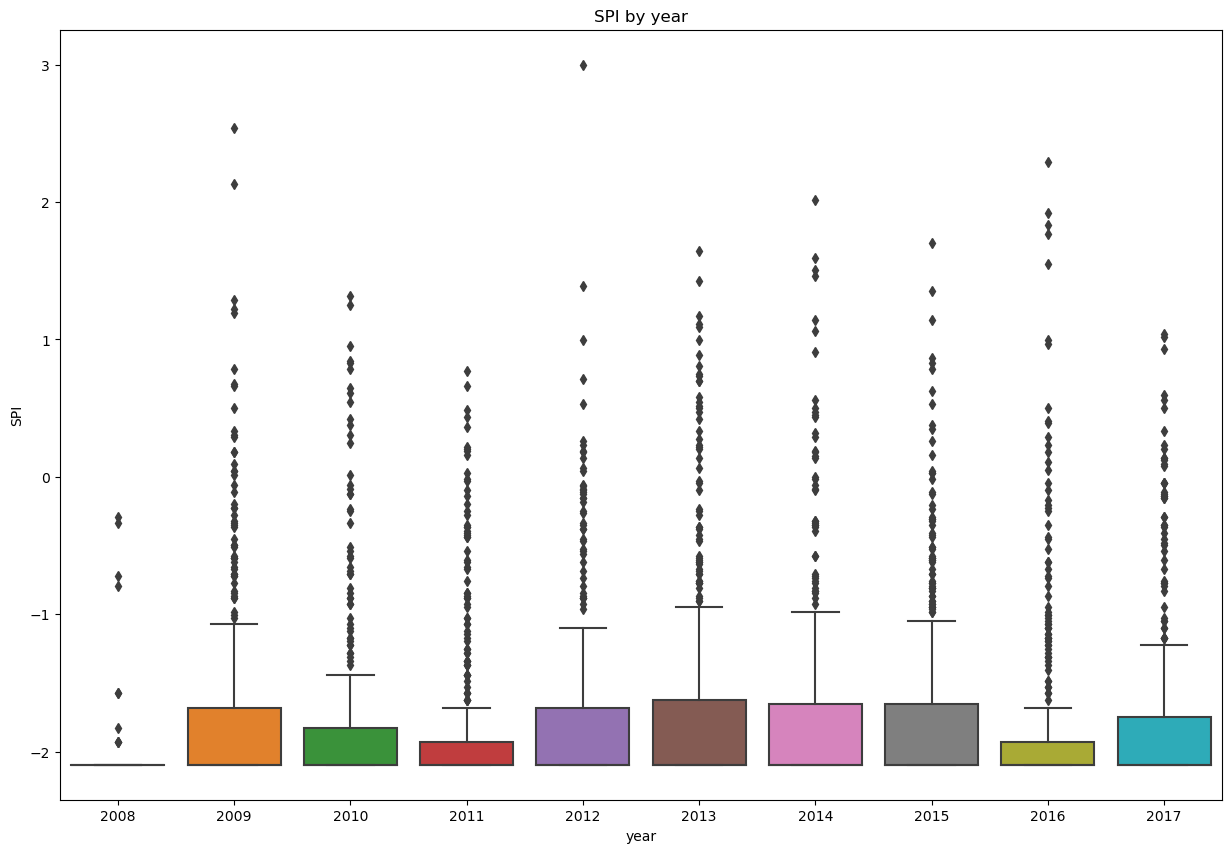

In [5]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=df, x='year', y='SPI')
ax.set_title('SPI by year')
plt.show()

In [6]:
df['SPI_EX_AVG'] = df['SPI'].ewm(span=30).mean()

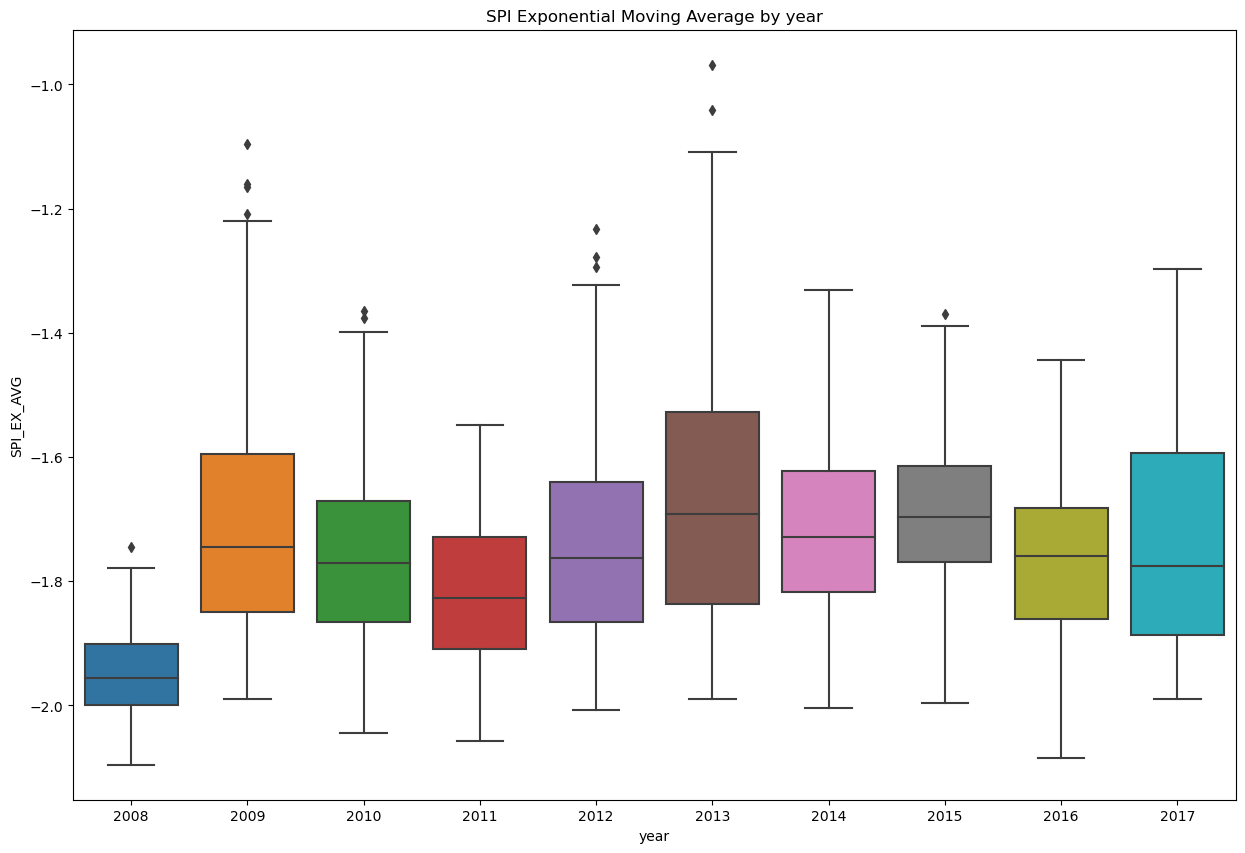

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=df, x='year', y='SPI_EX_AVG')
ax.set_title('SPI Exponential Moving Average by year')
plt.show()

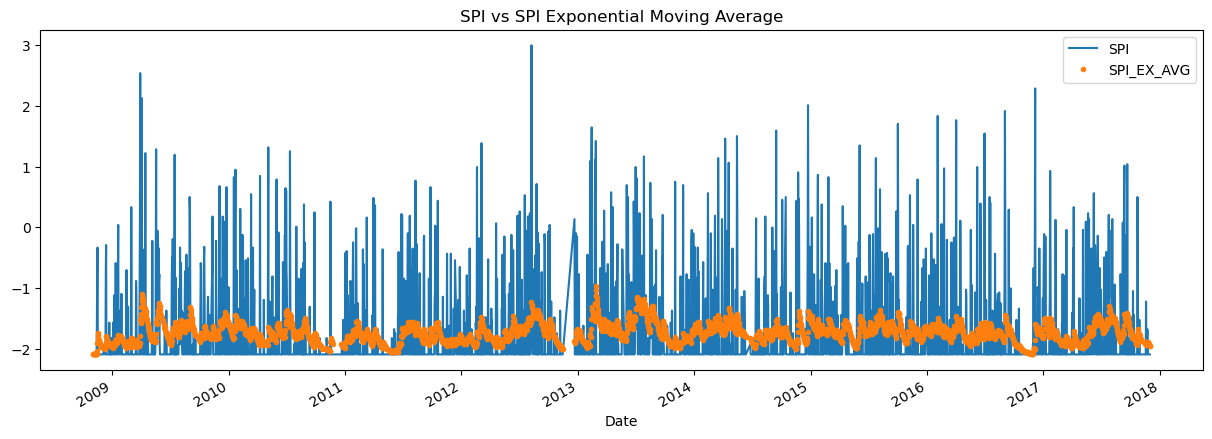

In [8]:
df[['SPI','SPI_EX_AVG']].plot(style=['-','.'],
            figsize=(15, 5),
            color=[color_pal[0], color_pal[1]],
            title="SPI vs SPI Exponential Moving Average"
            )
plt.show()

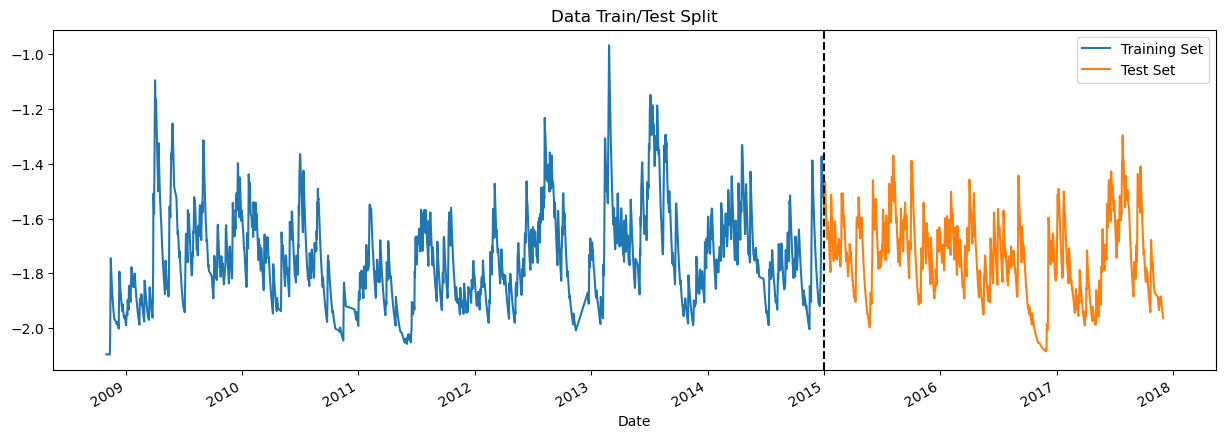

In [9]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']
fig, ax = plt.subplots(figsize=(15, 5))
train.SPI_EX_AVG.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.SPI_EX_AVG.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

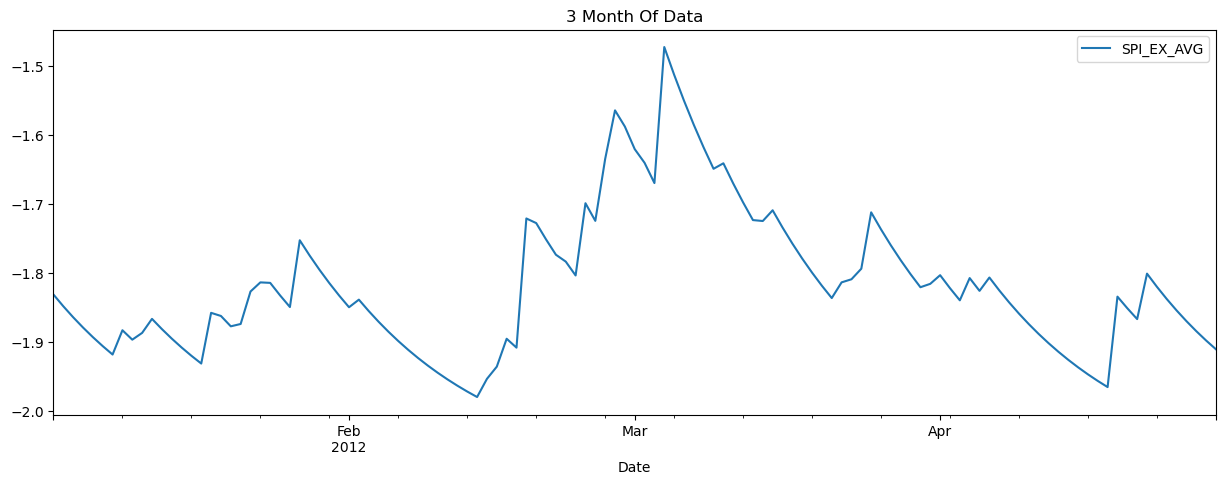

In [10]:
df[['SPI_EX_AVG']].loc[(df.index > '01-01-2012') & (df.index < '04-30-2012')].plot(figsize=(15, 5), title='3 Month Of Data')
plt.show()

## Outlier Analysis

<AxesSubplot:ylabel='Frequency'>

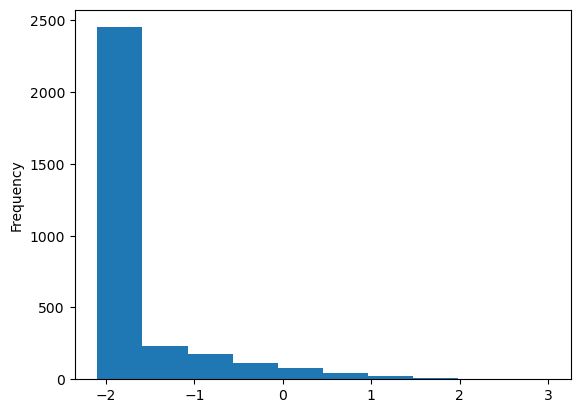

In [14]:
df['SPI'].plot(kind='hist', bins=10)

<AxesSubplot:title={'center':'Outliers'}, xlabel='Date'>

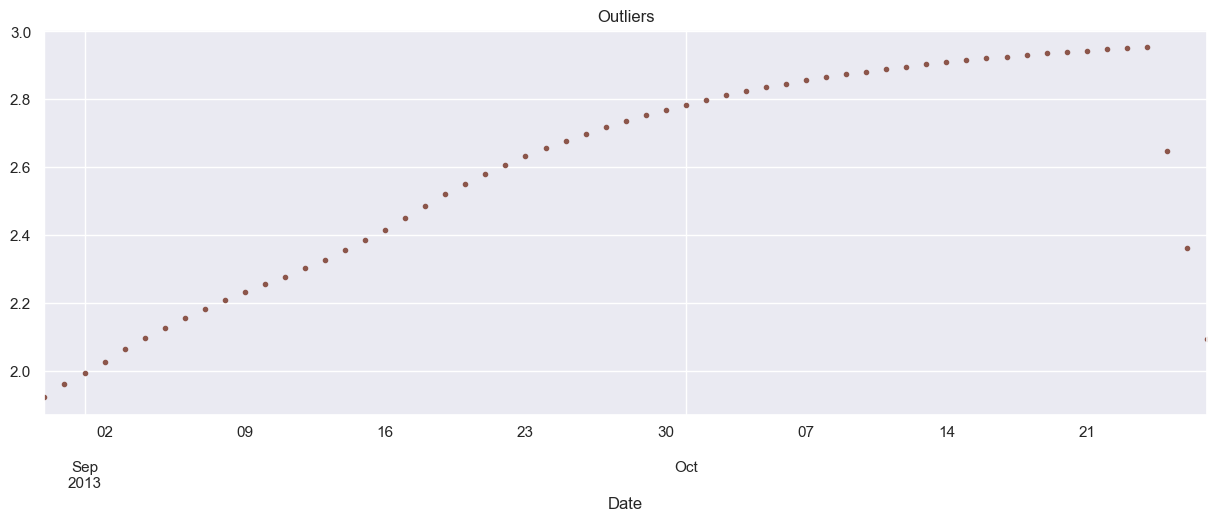

In [53]:
df.query('SPI_EX_AVG > 1.9')['SPI_EX_AVG'].plot(style='.',
                                figsize=(15, 5),
                                color=color_pal[5],
                                title='Outliers')

## Time series cross validation

In [11]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, gap=24)
df = df.sort_index()


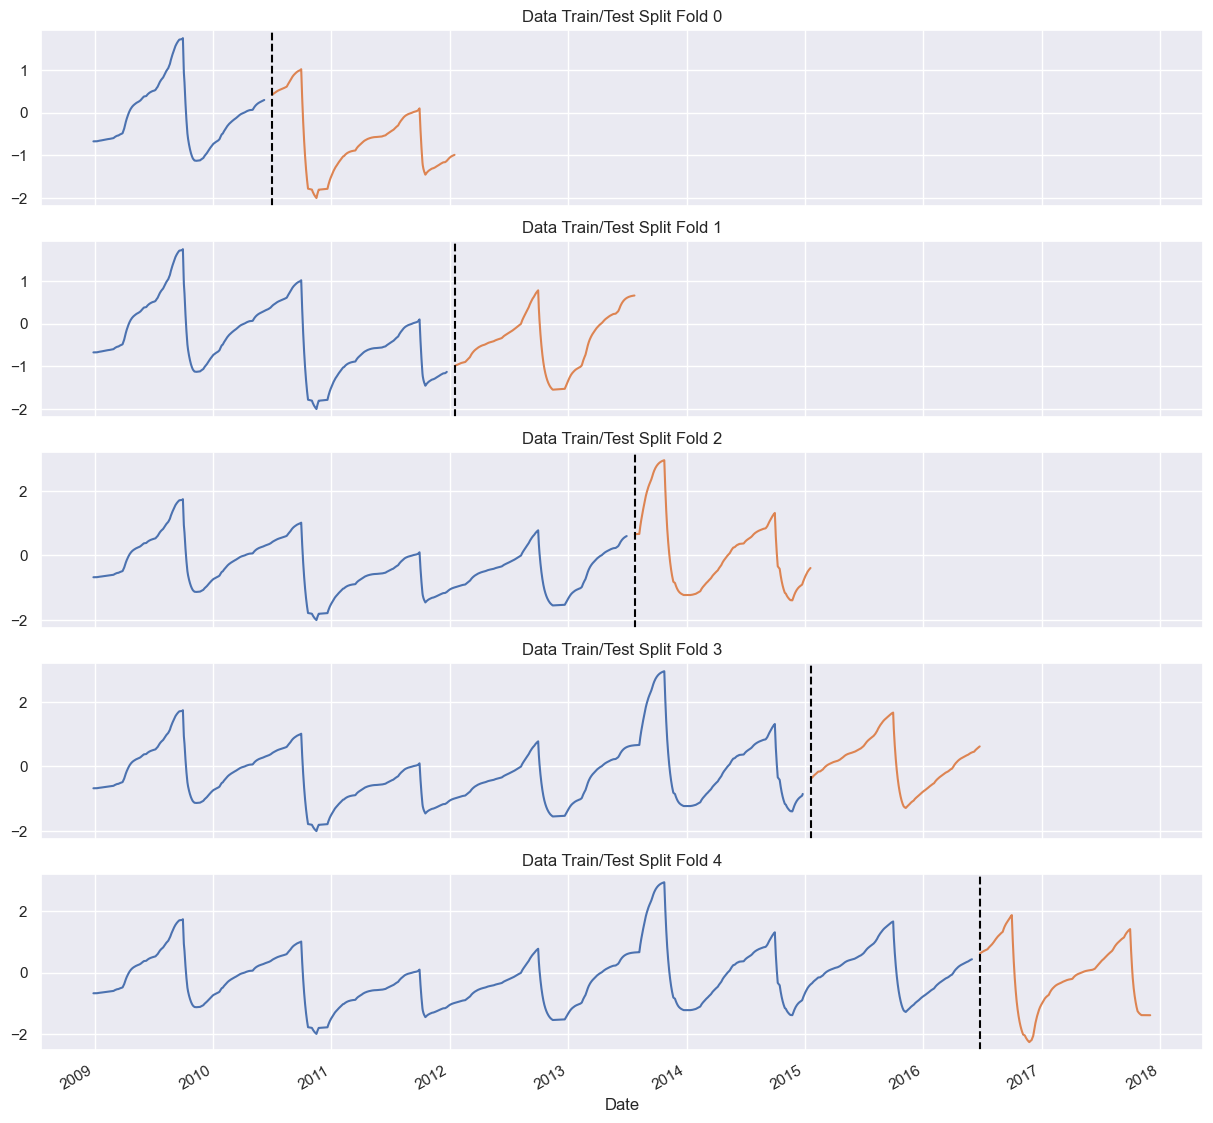

In [54]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['SPI_EX_AVG'].plot(ax=axs[fold],
                      label='Training Set',
                      title=f'Data Train/Test Split Fold {fold}')
    test['SPI_EX_AVG'].plot(ax=axs[fold],
                     label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [55]:

def add_lags(df):
    target_map = df['SPI_EX_AVG'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [56]:
df = add_lags(df)

In [57]:
df.head(1).transpose()

Date,2008-12-28
prcp_accum,11.800000
air_temp_avg,19.700000
smp_2,8.500000
smp_4,7.800000
smp_8,9.900000
smp_20,12.100000
smp_40,24.000000
soil_temp_2,15.900000
soil_temp_4,16.300000
soil_temp_8,16.800000


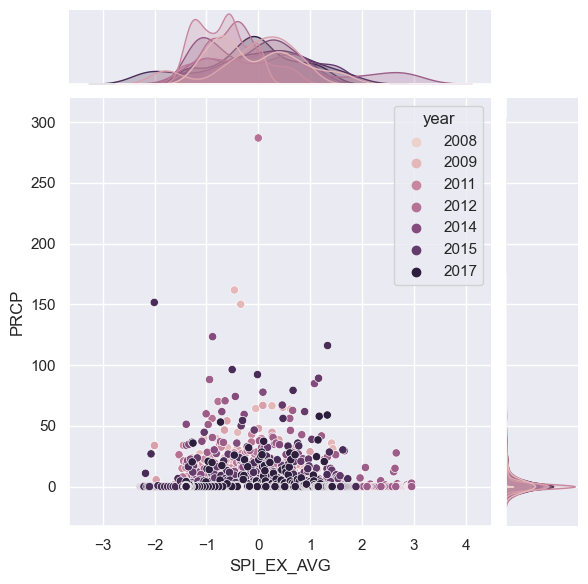

In [81]:
sns.jointplot(data=df, x=df['SPI_EX_AVG'], y=df['PRCP'], kind='scatter', hue='year')
plt.show()

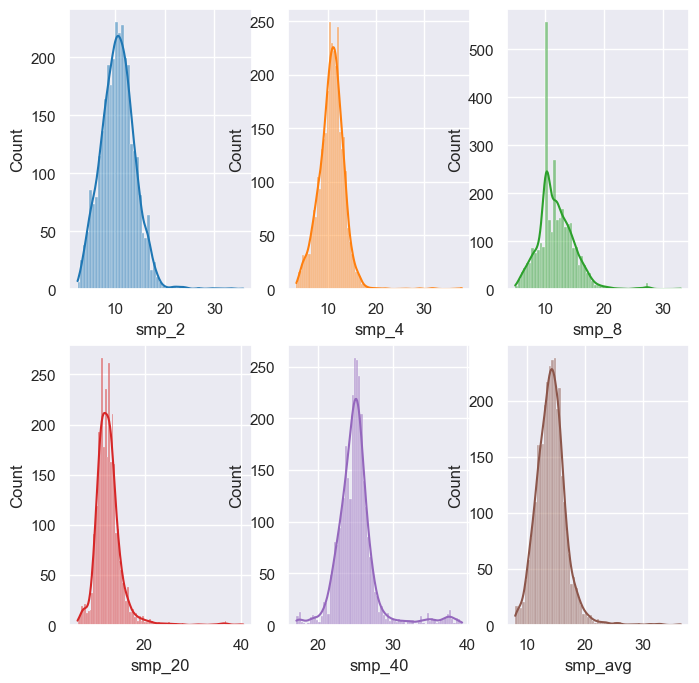

In [69]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 3, figsize=(8, 8))
sns.histplot(data=df, x='smp_2', kde=True, color=color_pal[0], ax=axs[0, 0])
sns.histplot(data=df, x='smp_4', kde=True, color=color_pal[1], ax=axs[0, 1])
sns.histplot(data=df, x='smp_8', kde=True, color=color_pal[2], ax=axs[0, 2])
sns.histplot(data=df, x='smp_20', kde=True, color=color_pal[3], ax=axs[1, 0])
sns.histplot(data=df, x='smp_40', kde=True, color=color_pal[4], ax=axs[1, 1])
sns.histplot(data=df, x='smp_avg', kde=True, color=color_pal[5], ax=axs[1, 2])
plt.show()

In [72]:
from sklearn.preprocessing import LabelEncoder



## Prepare for modeling ensemble

In [73]:

le = LabelEncoder()

df['season'] = le.fit_transform(df['season'])
df['weekday'] = le.fit_transform(df['weekday'])
df['day'] = le.fit_transform(df['day'])

In [76]:
df = df.drop(['SPI'], axis=1)
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

In [77]:
df.columns

Index(['prcp_accum', 'air_temp_avg', 'smp_2', 'smp_4', 'smp_8', 'smp_20',
       'smp_40', 'soil_temp_2', 'soil_temp_4', 'soil_temp_8', 'soil_temp_20',
       'soil_temp_40', 'wind_dir_avg', 'wind_speed_avg', 'PRCP', 'year',
       'month', 'day', 'hour', 'dayofweek', 'weekday', 'quarter', 'dayofyear',
       'dayofmonth', 'weekofyear', 'date_offset', 'week', 'season',
       'soil_temp_avg', 'smp_avg', 'DSCI', 'lag1', 'lag2', 'lag3',
       'SPI_EX_AVG'],
      dtype='object')

In [22]:
FEATURES = ['prcp_accum', 'air_temp_avg', 'smp_2', 'smp_4', 'smp_8', 'smp_20',
       'smp_40', 'soil_temp_2', 'soil_temp_4', 'soil_temp_8', 'soil_temp_20',
       'soil_temp_40', 'wind_dir_avg', 'wind_speed_avg', 'PRCP', 'year',
       'month', 'day', 'hour', 'dayofweek', 'weekday', 'quarter',
       'dayofyear', 'dayofmonth', 'weekofyear', 'date_offset', 'week',
       'season', 'soil_temp_avg', 'smp_avg', 'DSCI', 'lag1', 'lag2', 'lag3']
TARGET = 'SPI_EX_AVG'

In [23]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


In [24]:
numeric_features = FEATURES[0:15] + FEATURES[28:34]
numeric_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ],
    remainder='passthrough',
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['prcp_accum', 'air_temp_avg', 'smp_2',
                                  'smp_4', 'smp_8', 'smp_20', 'smp_40',
                                  'soil_temp_2', 'soil_temp_4', 'soil_temp_8',
                                  'soil_temp_20', 'soil_temp_40',
                                  'wind_dir_avg', 'wind_speed_avg', 'PRCP',
                                  'soil_temp_avg', 'smp_avg', 'DSCI', 'lag1',
                                  'lag2', 'lag3'])])

## Define Hyperopts - OBJ

In [25]:

from sklearn.model_selection import cross_val_score


def objective(args):
    pipe = Pipeline(steps=[('preprocessing', preprocessor),
        ('model', args['model'])
    ])

    X_train_tf = pipe[:-1].fit_transform(X_train)
    X_test_tf = pipe[:-1].fit_transform(X_test)


    pipe[-1].set_params(**args['params'])
    pipe[-1].fit(X_train_tf, y_train,  eval_set=[(X_train_tf, y_train), (X_test_tf, y_test)],
            verbose=0, early_stopping_rounds=10)
    score = cross_val_score(pipe, X_train_tf, y_train, cv=5, n_jobs=-1, error_score=0.99)
    return {'loss': 1 - np.median(score), 'status': STATUS_OK}


## Defining Hyperopts - Space

In [26]:
# Hyper Parameter Tuning

from sklearn.linear_model import LogisticRegression



space = hp.choice('classifiers', [
    {
        'model': xgb.XGBRegressor(),
        'params': {'max_depth': hp.choice("max_depth", [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]),
                   'gamma': hp.uniform('gamma', 1, 9),
                   'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
                   'reg_lambda': hp.uniform('reg_lambda', 0, 1),
                   'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                   'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
                   'n_estimators': hp.choice('n_estimators', [80,100,200,300,400,500]),
                   'learning_rate': hp.choice('learning_rate', [0.00001,0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]),
                   'seed': 0,

                   }
    }

])



In [27]:
from hyperopt import space_eval

trials = Trials()

best_classifier = fmin(objective, space, algo=tpe.suggest,
                       max_evals=200, trials=trials)


best_params = space_eval(space, best_classifier)

100%|██████████| 200/200 [00:54<00:00,  3.69trial/s, best loss: 0.010000000000000009]


In [28]:
best_params['model']

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6947130112164076,
             enable_categorical=False, gamma=5.494967575305795, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=17,
             min_child_weight=1.0, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=12, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=112.0, reg_lambda=0.7471985887148065,
             scale_pos_weight=1, seed=0, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [29]:
import joblib
joblib.dump(best_params['model'], './Models/Tuned_Large_XGBoost.pkl')

['./Models/Tuned_Large_XGBoost.pkl']

In [30]:
xgd_pipe = Pipeline(steps=[('preprocessing', preprocessor), ('reg',best_params['model'])])
xgd_pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['prcp_accum', 'air_temp_avg',
                                                   'smp_2', 'smp_4', 'smp_8',
                                                   'smp_20', 'smp_40',
                                                   'soil_temp_2', 'soil_temp_4',
                                                   'soil_temp_8',
                                                   'soil_temp_20',
                                                   'soil_temp_40',
                                                   'wind_dir_avg',
                                                   'wind...
                              interaction_constraints='', learning_rate=0.2,
                              max_delta_step=0, max_depth=17,
                              min_child_weight=1.0, missing=nan,
                              monotone_constraints='()', n_estimators=200,
                              n_jobs=12, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=112.0,
                              reg_lambda=0.7471985887148065, scale_pos_weight=1,
                              seed=0, subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [31]:

from sklearn.metrics import r2_score

train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_train_tf = xgd_pipe[:-1].fit_transform(X_train)
X_test_tf = xgd_pipe[:-1].fit_transform(X_test)

xgd_pipe[-1].fit(X_train_tf, y_train,  eval_set=[(X_train_tf, y_train), (X_test_tf, y_test)],
        verbose=0, early_stopping_rounds=30, eval_metric='rmse')


y_pred = xgd_pipe.predict(X_train)
# model = best_params['model'].fit(X_train_tf, y_train, eval_set=evaluation_2, eval_metric='rmse', early_stopping_rounds=10, verbose=False)
# y_pred = model.predict(X_train_tf)


# # TRAIN -- classification report and store predictions/ probabilities
print('Training R^2 Report for estimator: ',
      str(xgd_pipe[-1]).split('(')[0])
score = r2_score(y_train, y_pred)
print("The accuracy of our model is {}%".format(round(score, 2) *100))

Training R^2 Report for estimator:  XGBRegressor
The accuracy of our model is 80.0%


In [32]:

y_pred_test = xgd_pipe.predict(X_test)

# TEST -- classification report and store predictions/ probabilities
print('Testing R^2 Report for estimator: ',
      str(xgd_pipe[-1]).split('(')[0])
score = r2_score(y_test, y_pred_test)
print("The accuracy of our model is {}%".format(round(score, 2) *100))

Testing R^2 Report for estimator:  XGBRegressor
The accuracy of our model is 81.0%


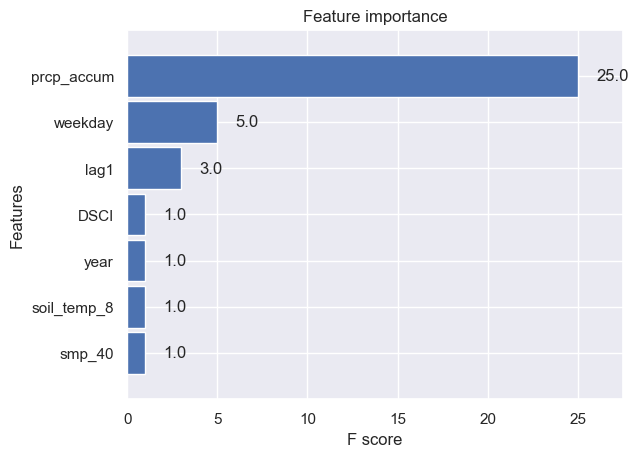

In [33]:
xgd_pipe[-1].get_booster().feature_names = FEATURES

_ = plot_importance(xgd_pipe[-1],height=0.9)

In [34]:
test['SPI_PRED'] = xgd_pipe.predict(X_test)
spi_all = pd.concat([train,test], sort = False)

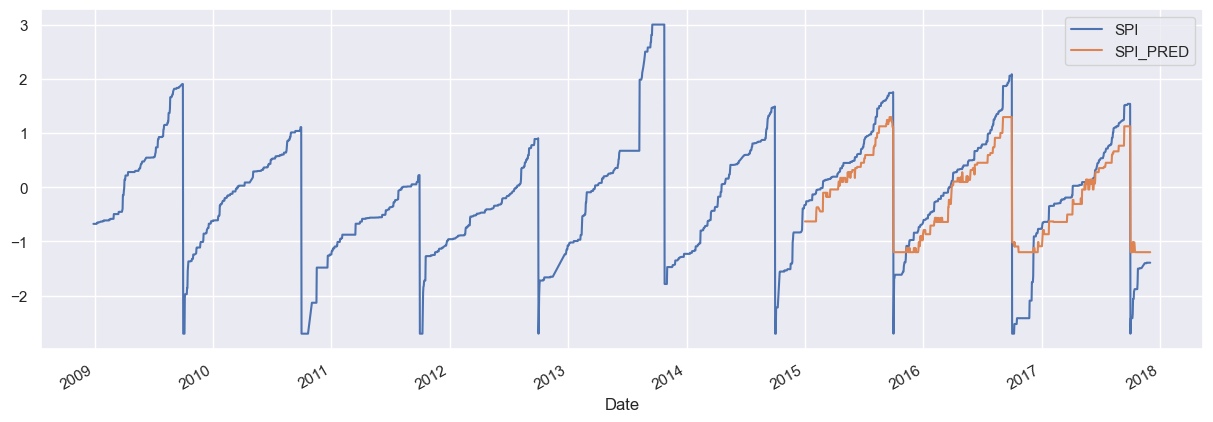

In [35]:


_ = spi_all[['SPI','SPI_PRED']].plot(figsize=(15, 5))



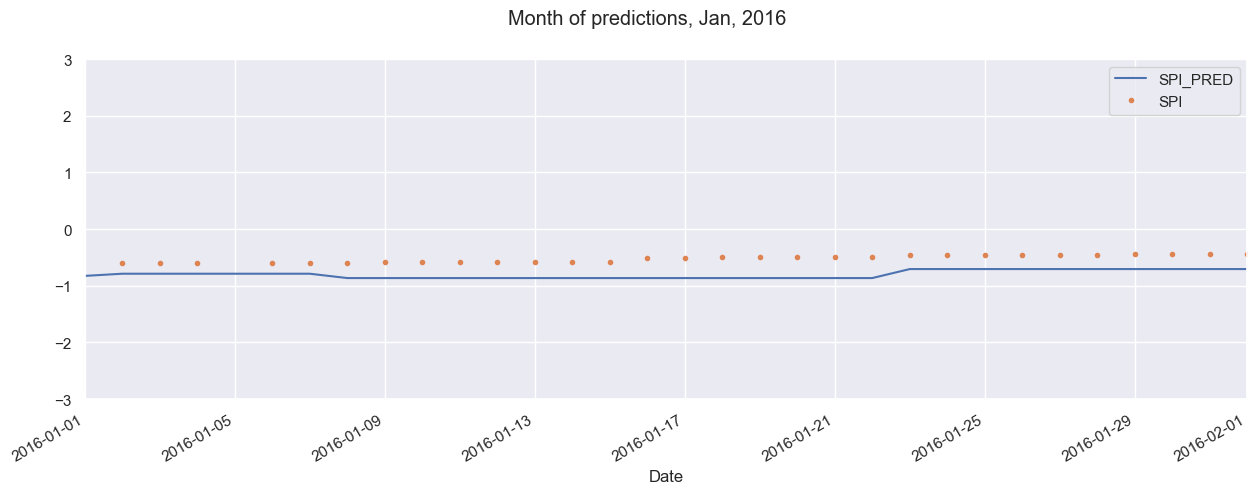

In [36]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = spi_all[['SPI_PRED','SPI']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(-3, 3)
ax.set_xbound(lower='01-01-2016', upper='02-01-2016')
plot = plt.suptitle('Month of predictions, Jan, 2016')

In [37]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



def collect_error_metrics(data, true_col, pred_col):

    RMSE = mean_squared_error(y_true=data[true_col],y_pred=data[pred_col])
    MAE = mean_absolute_error(y_true=data[true_col], y_pred=data[pred_col])
    MAPE = mean_absolute_percentage_error(y_true=data[true_col], y_pred=data[pred_col])


    return RMSE, MAE, MAPE


RMSE, MAE, MAPE = collect_error_metrics(test, 'SPI','SPI_PRED')

print('Our RMSE Error is', RMSE)
print('Our MAE Error is',MAE)
print('Our MAPE Error is', MAPE)


Our RMSE Error is 0.22636333759370622
Our MAE Error is 0.3887492481805585
Our MAPE Error is inf


In [38]:
SPI_test = test.copy()
SPI_test['error'] = SPI_test['SPI'] - SPI_test['SPI_PRED']
SPI_test['abs_error'] = SPI_test['error'].apply(np.abs)
error_by_month = SPI_test.groupby(['year', 'month']).mean()[['SPI','SPI_Prediction','error','abs_error']]

KeyError: "['SPI_Prediction'] not in index"

In [ ]:
# Worst Predicted year
error_by_month.sort_values('error', ascending=True).head(10)

In [ ]:
# Worst absolute Predicted Months
error_by_month.sort_values('abs_error', ascending=False).head(10)

In [ ]:
# Best Predicted Months
error_by_month.sort_values('abs_error', ascending=True).head(10)

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = spi_all[['SPI_PRED','SPI']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(-3, 3)
ax.set_xbound(lower='02-01-2016', upper='03-01-2016')
plot = plt.suptitle('February, 2016 - Worst Predicted Month')

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = spi_all[['SPI_PRED','SPI']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(-3, 3)
ax.set_xbound(lower='04-01-2015', upper='05-01-2015')
plot = plt.suptitle('April, 2015 - Best Predicted Month')